In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quantecon import LQ
from DynLinEcon import DLE
%matplotlib inline

//anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


# IRFs in Hall Models

This notebook shows how the DLE class can be used to create impulse response functions for three related economies, starting from Hall(1978).

Knowledge of the basic economic environment is assumed. See the notebook "Growth in Dynamic Linear Economies" for more details.

### Example 1: Hall (1978)

First, we set parameters such that consumption follows a random walk. In particular, we set:
$$ \lambda = 0, \pi = 1, \gamma_1 = 0.1, \phi_1 = 0.00001, \delta_k = 0.95, \beta = \frac{1}{1.05} $$
(In this example $\delta_h$ and $\theta_h$ are arbitrary as household capital does not enter the equation for consumption services. We set them to values that will become useful in Example 3.)

It is worth noting that this choice of parameter values ensures that $\beta(\gamma_1 + \delta_k) = 1$.

For simulations of this economy, we choose an initial condition of:
$$x_0 = 
   \left[ {\begin{array}{ccccc}
   5 & 150 & 1 & 0 & 0
   \end{array} } 
   \right]'
$$

In [2]:
gamma1 = 0.1
gamma = np.array([[gamma1],[0]])
phic = np.array([[1],[0]])
phig = np.array([[0],[1]])
phi1 = 0.00001
phii = np.array([[1],[-phi1]])
deltak = np.array([[.95]])
thetak = np.array([[1]])
beta = np.array([[1/1.05]])
llambda = np.array([[0]])
pih = np.array([[1]])
deltah = np.array([[.9]])
thetah = np.array([[1]])
a22 = np.array([[1,0,0],[0,0.8,0],[0,0,0.5]])
c2 = np.array([[0,0],[1,0],[0,1]])
ud = np.array([[5,1,0],[0,0,0]])
ub = np.array([[30,0,0]])
x0 = np.array([[5],[150],[1],[0],[0]])

Info1 = (a22,c2,ub,ud)
Tech1 = (phic,phig,phii,gamma,deltak,thetak)
Pref1 = (beta,llambda,pih,deltah,thetah)

These parameter values are used to define an economy of the DLE class. We can then simulate the economy for a chosen length of time, from our initial state vector $x_0$. The economy stores the simulated values for each variable. Below we plot consumption and investment:

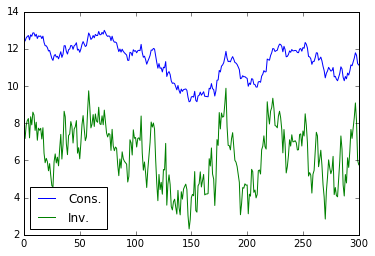

In [3]:
Econ1 = DLE(Info1, Tech1, Pref1)
Econ1.compute_sequence(x0,ts_length = 300)

# This is the right panel of Fig 5.7.1 from p.105 of HS2013
plt.plot(Econ1.c[0],label='Cons.')
plt.plot(Econ1.i[0],label='Inv.')
plt.legend(loc='Best')

The DLE class can be used to create impulse response functions for each of the endogenous variables: $\{c_t,s_t,h_t,i_t,k_t,g_t\}$. If no selector vector for the shock is specified, the default choice is to give IRFs to the first shock in $w_{t+1}$.

Below we plot the impulse response functions of investment and consumption to an endowment innovation (the first shock) in the Hall model:

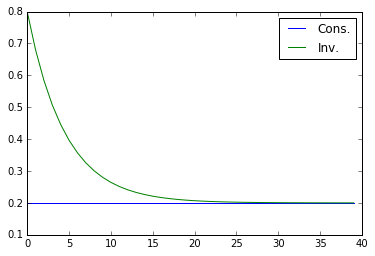

In [4]:
Econ1.irf(ts_length=40,shock=None)
# This is the left panel of Fig 5.7.1 from p.105 of HS2013
plt.plot(Econ1.c_irf,label='Cons.')
plt.plot(Econ1.i_irf,label='Inv.')
plt.legend(loc='Best')

It can be seen that the endowment shock has permanent effects on the level of both consumption and investment, consistent with the endogenous unit eigenvalue in this economy. Investment is much more response to the endowment shock at shorter time horizons.

### Example 2: Higher adjustment costs
We generate our next economy by making only one change to the parameters of Example 1: we raise the parameter associated with the cost of adjusting capital,$\phi_1$, from 0.00001 to 0.2. This will lower the endogenous eigenvalue that is unity in Example 1 to a value slightly below 1.


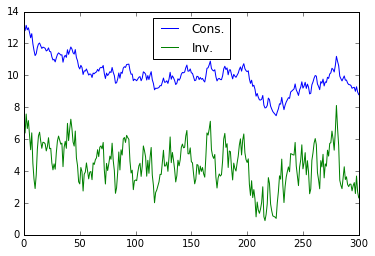

In [5]:
phi12 = 0.2
phii2 = np.array([[1],[-phi12]])
Tech2 = (phic,phig,phii2,gamma,deltak,thetak)

Econ2 = DLE(Info1, Tech2, Pref1)
Econ2.compute_sequence(x0,ts_length = 300)

# This is the right panel of Fig 5.8.1 from p.106 of HS2013
plt.plot(Econ2.c[0],label='Cons.')
plt.plot(Econ2.i[0],label='Inv.')
plt.legend(loc='Best')

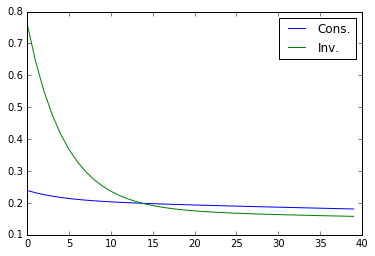

In [6]:
Econ2.irf(ts_length=40,shock=None)
# This is the left panel of Fig 5.8.1 from p.106 of HS2013
plt.plot(Econ2.c_irf,label='Cons.')
plt.plot(Econ2.i_irf,label='Inv.')
plt.legend(loc='Best')

In [7]:
Econ2.endo

array([ 0.9       ,  0.99657126])

In [8]:
Econ2.compute_steadystate()
print(Econ2.css, Econ2.iss, Econ2.kss)

[[ 5.]] [[  1.26228315e-11]] [[  2.52456630e-10]]


The first plot shows that there seems to be a downward trend in both consumption and investment. This is a consequence of the decrease in the largest endogenous eigenvalue from unity in the earlier economy, caused by the higher adjustment cost. 

The present economy has a nonstochastic steady state value of 5 for consumption and 0 for both capital and investment. As the largest endogenous eigenvalue is still close to 1, the economy heads only slowly towards these mean values.

The impulse response functions now show that an endowment shock does not a have permanent effect on the levels of either consumption or investment.

### Example 3: Durable Consumption Goods
We generate our third economy by raising $\phi_1$ further, to 1.0. We also raise the production function parameter from 0.1 to 0.15 (which raises the non-stochastic steady state value of capital above zero).

We also change the specification of preferences to make the consumption good *durable*. Specifically, we allow for a single durable household good obeying:
$$ h_t = \delta_h h_{t-1} + c_t \, ,  0<\delta_h<1 $$

Services are related to the stock of durables at the beginning of the period:
$$ s_t = \lambda h_{t-1} \, ,  \lambda > 0$$

And preferences are ordered by:
$$ - \frac{1}{2} \mathbb{E} \sum_{t=0}^\infty \beta^t [(\lambda h_{t-1} - b_t)^2 + l_t^2]|J_0 $$

To implement this, we set $\lambda=0.1$ and $\pi = 0$ (we have already set $\theta_h = 1$ and $\delta_h = 0.9$). 

We start from a different initial condition, such that consumption begins around its non-stochastic steady state.

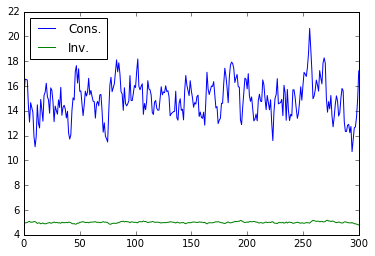

In [9]:
phi13 = 1
phii3 = np.array([[1],[-phi13]])

gamma12 = 0.15
gamma2 = np.array([[gamma12],[0]])

llambda2 = np.array([[0.1]])
pih2 = np.array([[0]])

x01 = np.array([[150],[100],[1],[0],[0]])

Tech3 = (phic,phig,phii3,gamma2,deltak,thetak)
Pref2 = (beta,llambda2,pih2,deltah,thetah)

Econ3 = DLE(Info1, Tech3, Pref2)
Econ3.compute_sequence(x01,ts_length = 300)

# This is the right panel of Fig 5.11.1 from p.111 of HS2013
plt.plot(Econ3.c[0],label='Cons.')
plt.plot(Econ3.i[0],label='Inv.')
plt.legend(loc='Best')

In contrast to Hall's original model of Example 1, it is now investment that is much smoother than consumption. This illustrates how making consumption goods durable tends to undo the strong consumption smoothing result that Hall obtained.

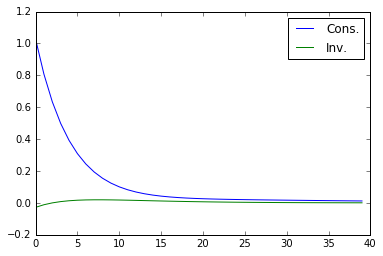

In [10]:
Econ3.irf(ts_length=40,shock=None)
# This is the left panel of Fig 5.11.1 from p.111 of HS2013
plt.plot(Econ3.c_irf,label='Cons.')
plt.plot(Econ3.i_irf,label='Inv.')
plt.legend(loc='Best')

The impulse response functions confirm that consumption is now much more responsive to an endowment shock (and investment less so) than in Example 1. As in Example 2, the endowment shock does not have permanent effects on either variable.